In [28]:
import numpy as np
import pandas as pd
import customFunctions as fct
import foxes
import foxes.variables as FV
import foxes.input.farm_layout as layout
from foxes import algorithms
from foxes.output import FarmResultsEval
import matplotlib.pyplot as plt
import os
os.environ["FOXES_ENGINE"]    = "threads"
os.environ["FOXES_N_PROCS"]   = "1"

# 1) Load & prepare ERA5 from reanalysis.csv
era5 = pd.read_csv("reanalysis.csv", index_col=0, parse_dates=True)
era5.rename(columns={"WS100":"WS","WD100":"WD"}, inplace=True)
era5.replace(-999, np.nan, inplace=True)
era5 = era5.resample("h").mean()
era5.index = pd.to_datetime(era5.index)
era5 = era5.loc["2006-01-01":"2006-12-31"]

# 2) Ensure turbulence intensity column exists
if "TI" not in era5.columns:
    era5["TI"] = 0.10  
    
test_algo = fct.setup_algo(era5)


Turbine 0, T0: xy=(299005.80, 6070368.13), DTU10MW
Turbine 1, T1: xy=(298349.95, 6069364.01), DTU10MW
Turbine 2, T2: xy=(299546.60, 6069298.19), DTU10MW
Turbine 3, T3: xy=(300744.40, 6069255.93), DTU10MW
Turbine 4, T4: xy=(302075.57, 6068404.37), DTU10MW
Turbine 5, T5: xy=(298529.18, 6068179.05), DTU10MW
Turbine 6, T6: xy=(299725.82, 6068113.23), DTU10MW
Turbine 7, T7: xy=(300923.62, 6068070.97), DTU10MW
Turbine 8, T8: xy=(297371.96, 6067866.68), DTU10MW
Turbine 9, T9: xy=(303085.54, 6067758.28), DTU10MW
Turbine 10, T10: xy=(301715.50, 6067171.26), DTU10MW
Turbine 11, T11: xy=(304095.51, 6067112.19), DTU10MW
Turbine 12, T12: xy=(299341.24, 6066978.00), DTU10MW
Turbine 13, T13: xy=(298142.83, 6066947.93), DTU10MW
Turbine 14, T14: xy=(300539.04, 6066935.73), DTU10MW
Turbine 15, T15: xy=(302771.25, 6066601.55), DTU10MW
Turbine 16, T16: xy=(305105.47, 6066466.11), DTU10MW
Turbine 17, T17: xy=(301478.71, 6065995.11), DTU10MW
Turbine 18, T18: xy=(303781.22, 6065955.46), DTU10MW
Turbine 19, T

In [29]:
[turbine_stats1, summary1]= fct.compute_yield(test_algo)
print(summary1)
#print(turbine_stats)

Selecting 'DefaultEngine(n_procs=12, chunk_size_states=None, chunk_size_points=None)'
DefaultEngine: Selecting engine 'process'
ProcessEngine: Calculating 8760 states for 133 turbines
ProcessEngine: Computing 12 chunks using 12 processes








  0%|          | 0/12 [00:00<?, ?it/s]





  8%|▊         | 1/12 [00:02<00:26,  2.43s/it]





 17%|█▋        | 2/12 [00:03<00:17,  1.77s/it]





 50%|█████     | 6/12 [00:04<00:02,  2.10it/s]





100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Capacity added to farm results
Ambient capacity added to farm results
Efficiency added to farm results
{'farm_ambient_power_MW': np.float64(795.9246788419321), 'farm_net_power_MW': np.float64(681.4971947385419), 'farm_efficiency': np.float64(0.8562332754025397), 'annual_yield_GWh': np.float64(5969.9154259096285)}


### Actually the Algorithm (here: "test_algo") is the kind of Object having the Farm and the States within its scope. Here is an example how one can get the farm object or the layout back from the perviously created Algorithm object:

In [4]:
# retrieving the wind farm from the algorithm object and give out a property of this wind farm instance
print(test_algo.farm.name)

my_farm


DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating 8760 states for 1 turbines
SingleChunkEngine: Running single chunk calculation for 8760 states


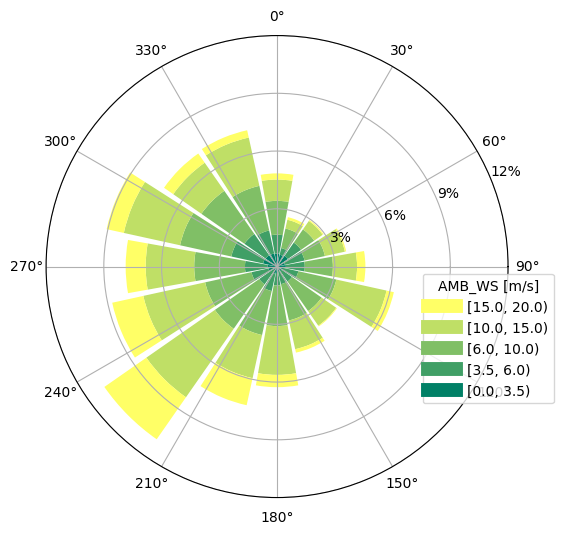

In [5]:
# retrieving the states from the algorithm object and generate a windrose from it
my_states = test_algo.states
o = foxes.output.StatesRosePlotOutput(my_states, point=[0.0, 0.0, 100.0])
o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()


# Redoing task 5 with the new functions

In [6]:
# see what options are already available among the build in models
mbook = foxes.models.ModelBook()
mbook.print_toc()

axial_induction
---------------
Betz: BetzAxialInduction()
Madsen: MadsenAxialInduction()

farm_controllers
----------------
basic_ctrl: BasicFarmController()

farm_models
-----------
farm_PMask: Turbine2FarmModel(PowerMask(var_ws_P=REWS3, P_lim=100, induction=Betz))
farm_hubh_data: Turbine2FarmModel(RotorCentreCalc())
farm_kTI: Turbine2FarmModel(kTI(kTI=None, kb=0, ti_var=TI, k_var=k))
farm_kTI_amb: Turbine2FarmModel(kTI(kTI=None, kb=0, ti_var=AMB_TI, k_var=k))
farm_thrust2ct: Turbine2FarmModel(Thrust2Ct(thrust_var=T, var_ws_ct=REWS2))
farm_yaw2yawm: Turbine2FarmModel(YAW2YAWM())
farm_yawm2yaw: Turbine2FarmModel(YAWM2YAW())

ground_models
-------------
ground_mirror: GroundMirror()
no_ground: NoGround()

blh_mirror_h<height>: WakeMirror with
  height=(Boundary layer wake reflection height)
Example: blh_mirror_h500

partial_wakes
-------------
centre: PartialCentre()
rotor_points: RotorPoints()
top_hat: PartialTopHat()

axiwake<n>: PartialAxiwake with
  n=(Number of evaluation points)


### 1) create a new wind turbine model from the power curve files

In [7]:
    # define data file path
costum_turbine_data = 'turbine-info/power_curves/IEA-15MW-D240-H150.csv'

# add a new model to the book
mbook.turbine_types['custom_turbine'] = foxes.models.turbine_types.PCtFile(costum_turbine_data,rho = 1.225)

# show model specs
mbook.turbine_types['custom_turbine']

PCtFile(D=240.0, H=150.0, P_nominal=15000.0, P_unit=kW, rho=1.225, var_ws_ct=REWS2, var_ws_P=REWS3)

### 2) use a different wake model

In [49]:
#wake_models = ['TurbOPark_quadratic_loc_k004','Jensen_quadratic_k0075']
wake_models = ["Bastankhah2014_linear_k004","IECTI2019k_linear_k004"]

### Initate new foxes algorithm

In [50]:
chosen_turbine = None
#choosen_turbine = ['custom_turbine']

alternative_algo1 = fct.setup_algo(era5,'alternative_farm1',wake_models = wake_models,model_book=mbook,turbine_key=chosen_turbine)

Turbine 0, T0: xy=(299005.80, 6070368.13), DTU10MW
Turbine 1, T1: xy=(298349.95, 6069364.01), DTU10MW
Turbine 2, T2: xy=(299546.60, 6069298.19), DTU10MW
Turbine 3, T3: xy=(300744.40, 6069255.93), DTU10MW
Turbine 4, T4: xy=(302075.57, 6068404.37), DTU10MW
Turbine 5, T5: xy=(298529.18, 6068179.05), DTU10MW
Turbine 6, T6: xy=(299725.82, 6068113.23), DTU10MW
Turbine 7, T7: xy=(300923.62, 6068070.97), DTU10MW
Turbine 8, T8: xy=(297371.96, 6067866.68), DTU10MW
Turbine 9, T9: xy=(303085.54, 6067758.28), DTU10MW
Turbine 10, T10: xy=(301715.50, 6067171.26), DTU10MW
Turbine 11, T11: xy=(304095.51, 6067112.19), DTU10MW
Turbine 12, T12: xy=(299341.24, 6066978.00), DTU10MW
Turbine 13, T13: xy=(298142.83, 6066947.93), DTU10MW
Turbine 14, T14: xy=(300539.04, 6066935.73), DTU10MW
Turbine 15, T15: xy=(302771.25, 6066601.55), DTU10MW
Turbine 16, T16: xy=(305105.47, 6066466.11), DTU10MW
Turbine 17, T17: xy=(301478.71, 6065995.11), DTU10MW
Turbine 18, T18: xy=(303781.22, 6065955.46), DTU10MW
Turbine 19, T

### run simulation and evaluate results

In [51]:
[turbine_stats2, summary2] = fct.compute_yield(alternative_algo1)
summary2

Selecting 'DefaultEngine(n_procs=12, chunk_size_states=None, chunk_size_points=None)'
DefaultEngine: Selecting engine 'process'
ProcessEngine: Calculating 8760 states for 133 turbines
ProcessEngine: Computing 12 chunks using 12 processes











  0%|          | 0/12 [00:00<?, ?it/s]

TypeError: 'NoneType' object cannot be interpreted as an integer

## Change to yet another wake model, run a simulation and show results

In [52]:
wake_models = ["TurbOPark_quadratic_loc_k004","CrespoHernandez_max_k004"]
alternative_algo2 = fct.setup_algo(era5,'alternative_farm',rotor_model = 'grid36',wake_models=wake_models,model_book=mbook,turbine_key= choosen_turbine)
[turbine_stats3, summary3] = fct.compute_yield(alternative_algo2)

Turbine 0, T0: xy=(299005.80, 6070368.13), DTU10MW
Turbine 1, T1: xy=(298349.95, 6069364.01), DTU10MW
Turbine 2, T2: xy=(299546.60, 6069298.19), DTU10MW
Turbine 3, T3: xy=(300744.40, 6069255.93), DTU10MW
Turbine 4, T4: xy=(302075.57, 6068404.37), DTU10MW
Turbine 5, T5: xy=(298529.18, 6068179.05), DTU10MW
Turbine 6, T6: xy=(299725.82, 6068113.23), DTU10MW
Turbine 7, T7: xy=(300923.62, 6068070.97), DTU10MW
Turbine 8, T8: xy=(297371.96, 6067866.68), DTU10MW
Turbine 9, T9: xy=(303085.54, 6067758.28), DTU10MW
Turbine 10, T10: xy=(301715.50, 6067171.26), DTU10MW
Turbine 11, T11: xy=(304095.51, 6067112.19), DTU10MW
Turbine 12, T12: xy=(299341.24, 6066978.00), DTU10MW
Turbine 13, T13: xy=(298142.83, 6066947.93), DTU10MW
Turbine 14, T14: xy=(300539.04, 6066935.73), DTU10MW
Turbine 15, T15: xy=(302771.25, 6066601.55), DTU10MW
Turbine 16, T16: xy=(305105.47, 6066466.11), DTU10MW
Turbine 17, T17: xy=(301478.71, 6065995.11), DTU10MW
Turbine 18, T18: xy=(303781.22, 6065955.46), DTU10MW
Turbine 19, T











  0%|          | 0/12 [00:56<?, ?it/s]


TypeError: 'NoneType' object cannot be interpreted as an integer

## plotting differences of 3 simulations

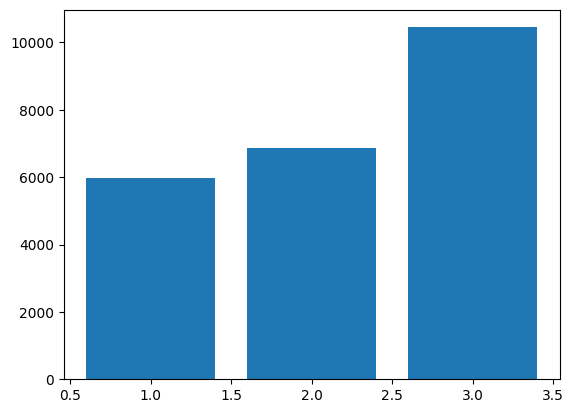

In [16]:
# compare annual yield of total wind park for different simulations 1:3
plt.bar([3,2,1],[summary3['annual_yield_GWh'],summary2['annual_yield_GWh'],summary1['annual_yield_GWh']])
plt.show()

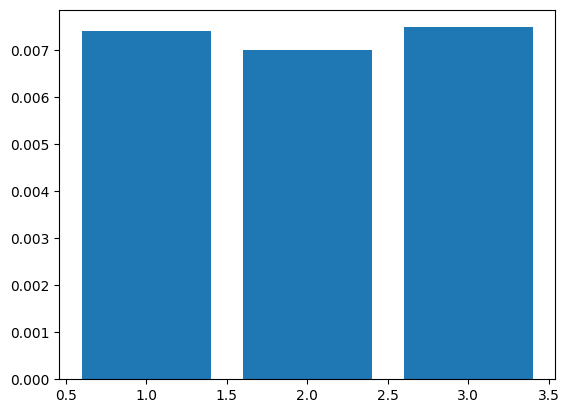

In [69]:
# compare values for single turbine
Turbine_ID = 'T80'
compare_single_turbine_stats = pd.DataFrame([turbine_stats3.loc[Turbine_ID], turbine_stats2.loc[Turbine_ID],turbine_stats1.loc[Turbine_ID]])

# share of choosen turbine from total yield
single_tubine_energy_contribution = compare_single_turbine_stats.iloc[:,1]/[summary3['annual_yield_GWh'],summary2['annual_yield_GWh'],summary1['annual_yield_GWh']]

plt.bar([3,2,1],single_tubine_energy_contribution)
plt.show()